GIF saved as 'particle_filter_animation_with_prediction.gif'


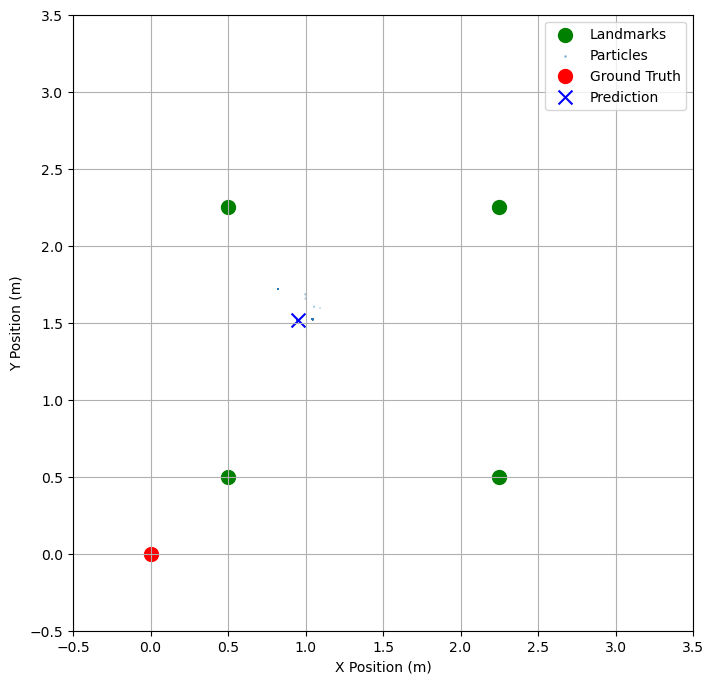

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd

# Constants
DELTA_T = 0.1  # Time step (seconds)
AREA_LIMIT = 3.0  # 3x3 square
NUM_PARTICLES = 10000  # Number of particles
MOTION_NOISE = [0.1, 0.1, np.deg2rad(1)]  # Noise in [x, y, theta]
LANDMARKS = [[0.5, 0.5], [2.25, 0.5], [2.25, 2.25], [0.5, 2.25]]  # Landmarks in the area

# Load tf_data (ground truth as input for now)
def load_tf_data(filename):
    """Load tf_data (ground truth) from a CSV file."""
    df = pd.read_csv(filename)
    return df['translation_x'], df['translation_y'], df['rotation_z']

# Particle Filter Class
class ParticleFilter:
    def __init__(self, num_particles, area_limit):
        self.num_particles = num_particles
        self.area_limit = area_limit
        # Initialize particles uniformly within the area
        self.particles = np.zeros((num_particles, 3))  # [x, y, theta]
        self.particles[:, 0] = np.random.uniform(0, area_limit, num_particles)  # x
        self.particles[:, 1] = np.random.uniform(0, area_limit, num_particles)  # y
        self.particles[:, 2] = np.random.uniform(-np.pi, np.pi, num_particles)  # theta
        self.weights = np.ones(num_particles) / num_particles

    def predict(self, control_input):
        """Propagate particles using the motion model with noise."""
        v, omega = control_input  # Linear and angular velocity
        noise = np.random.normal(0, MOTION_NOISE, (self.num_particles, 3))
        self.particles[:, 2] += omega * DELTA_T + noise[:, 2]  # Update theta
        self.particles[:, 2] = (self.particles[:, 2] + np.pi) % (2 * np.pi) - np.pi  # Normalize angle
        self.particles[:, 0] += (v * np.cos(self.particles[:, 2]) * DELTA_T + noise[:, 0])  # Update x
        self.particles[:, 1] += (v * np.sin(self.particles[:, 2]) * DELTA_T + noise[:, 1])  # Update y
        # Clamp particles to the area limit
        self.particles[:, 0] = np.clip(self.particles[:, 0], 0, self.area_limit)
        self.particles[:, 1] = np.clip(self.particles[:, 1], 0, self.area_limit)

    def update(self, measurements, measurement_noise, landmarks):
        """Update particle weights based on measurements to landmarks."""
        for i, landmark in enumerate(landmarks):
            # Calculate expected distances to this landmark for all particles
            expected_distances = np.sqrt((self.particles[:, 0] - landmark[0])**2 + 
                                         (self.particles[:, 1] - landmark[1])**2)
            # Actual distance measurement for this landmark
            actual_distance = measurements[i]
            
            # Calculate weights based on Gaussian likelihood
            self.weights *= np.exp(-0.5 * ((expected_distances - actual_distance) / measurement_noise[0])**2)
        
        # Normalize weights
        self.weights /= np.sum(self.weights)

    def resample(self):
        """Resample particles based on their weights."""
        indices = np.random.choice(range(self.num_particles), size=self.num_particles, p=self.weights)
        self.particles = self.particles[indices]
        self.weights.fill(1.0 / self.num_particles)  # Reset weights

    def estimate(self):
        """Estimate the state as the weighted mean of the particles."""
        mean = np.average(self.particles, weights=self.weights, axis=0)
        covariance = np.cov(self.particles.T, aweights=self.weights)
        return mean, covariance

# Simulate Landmark Measurements
def simulate_landmark_measurements(ground_truth, landmarks, noise_std):
    """Simulate measurements from the ground truth position to landmarks."""
    measurements = []
    for landmark in landmarks:
        distance = np.sqrt((ground_truth[0] - landmark[0])**2 + (ground_truth[1] - landmark[1])**2)
        noisy_distance = distance + np.random.normal(0, noise_std)
        measurements.append(noisy_distance)
    return measurements

# Load tf_data (assuming the file is named 'tf_data.csv')
tf_x, tf_y, tf_theta = load_tf_data('tf_data copy.csv')
ground_truth = np.vstack((tf_x, tf_y, tf_theta)).T

# Initialize Particle Filter
pf = ParticleFilter(NUM_PARTICLES, AREA_LIMIT)

# Initialize figure
fig, ax = plt.subplots(figsize=(8, 8))
landmark_scatter = ax.scatter([l[0] for l in LANDMARKS], [l[1] for l in LANDMARKS],
                               color='green', label='Landmarks', s=100)
particles_scatter = ax.scatter([], [], s=[], alpha=0.4, label='Particles')
ground_truth_scatter = ax.scatter([], [], color='red', label='Ground Truth', s=100)
predicted_scatter = ax.scatter([], [], color='blue', marker='x', label='Prediction', s=100)
ax.set_xlim(-0.5, AREA_LIMIT + 0.5)
ax.set_ylim(-0.5, AREA_LIMIT + 0.5)
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.legend()
ax.grid()

# Animation update function
def update(frame):
    control_input = [0.5, np.deg2rad(5)]  # Example control input
    measurement = simulate_landmark_measurements(ground_truth[frame], LANDMARKS, noise_std=0.2)

    # Particle filter steps
    pf.predict(control_input)
    pf.update(measurement, measurement_noise=[0.2], landmarks=LANDMARKS)
    pf.resample()

    # Estimate the state
    estimated_mean, _ = pf.estimate()

    particles_scatter.set_offsets(pf.particles[:, :2])
    particles_scatter.set_sizes(pf.weights * 1000)
    ground_truth_scatter.set_offsets([ground_truth[frame, 0], ground_truth[frame, 1]])
    predicted_scatter.set_offsets([estimated_mean[0], estimated_mean[1]])
    return particles_scatter, ground_truth_scatter, predicted_scatter

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(ground_truth) - 1, interval=200, blit=False)

# Save as GIF
ani.save('particle_filter_animation_with_prediction.gif', writer='pillow', fps=10)

print("GIF saved as 'particle_filter_animation_with_prediction.gif'")


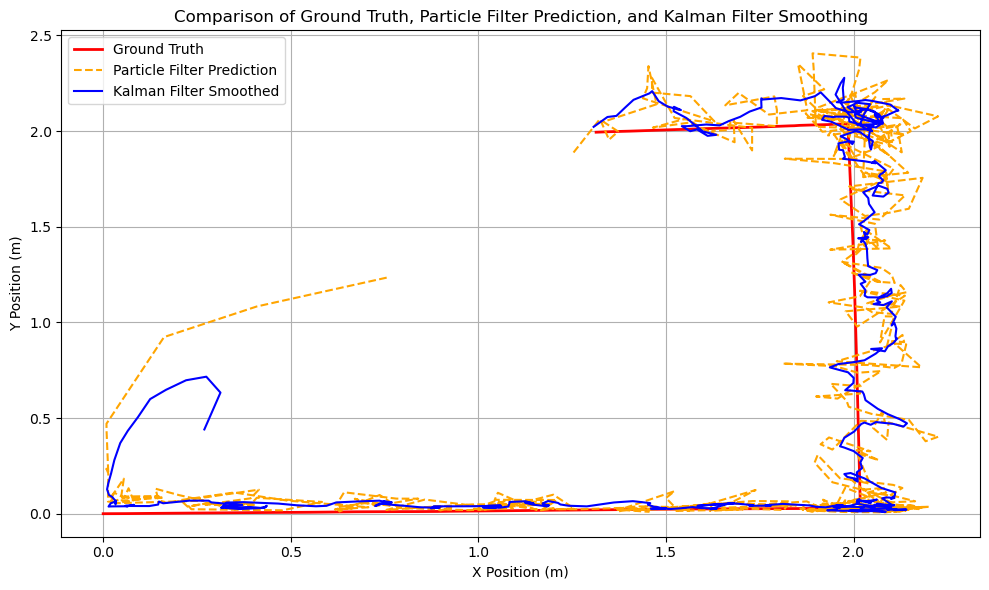

In [2]:
# Kalman Filter Class for Smoothing
class KalmanFilter:
    def __init__(self, initial_state, initial_covariance, process_noise, measurement_noise):
        self.state = initial_state  # [x, y, vx, vy]
        self.covariance = initial_covariance  # Covariance matrix
        self.process_noise = process_noise  # Process noise covariance
        self.measurement_noise = measurement_noise  # Measurement noise covariance
        self.measurement_matrix = np.eye(2, 4)  # Maps state to measurement space

    def predict(self, control_input):
        """Predict the next state and covariance."""
        # Motion model: x' = F * x + B * u
        # F: State transition matrix, B: Control input matrix
        F = np.eye(4)
        F[0, 2] = DELTA_T  # Position depends on velocity
        F[1, 3] = DELTA_T

        # Control input matrix B (zero in this case, as no control input here)
        B = np.zeros((4, 2))

        # Predict state
        self.state = F @ self.state + B @ control_input

        # Predict covariance
        self.covariance = F @ self.covariance @ F.T + self.process_noise

    def update(self, measurement):
        """Update the state with a new measurement."""
        # Innovation
        z = measurement  # Measurement [x, y]
        y = z - self.measurement_matrix @ self.state  # Measurement residual

        # Kalman Gain
        S = self.measurement_matrix @ self.covariance @ self.measurement_matrix.T + self.measurement_noise
        K = self.covariance @ self.measurement_matrix.T @ np.linalg.inv(S)

        # Update state
        self.state = self.state + K @ y

        # Update covariance
        I = np.eye(len(self.state))
        self.covariance = (I - K @ self.measurement_matrix) @ self.covariance

    def get_state(self):
        """Return the current state estimate."""
        return self.state[:2]  # Only return x, y (position)

# Initialize Kalman Filter
initial_state = np.array([0, 0, 0, 0])  # [x, y, vx, vy]
initial_covariance = np.eye(4) * 0.1
process_noise = np.eye(4) * 0.01  # Small process noise
measurement_noise = np.eye(2) * 0.2  # Measurement noise (depends on Particle Filter accuracy)

kf = KalmanFilter(initial_state, initial_covariance, process_noise, measurement_noise)

# Simulate Particle Filter with Kalman Smoothing
smoothed_positions = []  # Store Kalman Filter smoothed positions
raw_predictions = []  # Store Particle Filter predictions

for frame in range(len(ground_truth) - 1):
    control_input = [0.5, np.deg2rad(5)]  # Example control input (v, omega)
    measurement = simulate_landmark_measurements(ground_truth[frame], LANDMARKS, noise_std=0.2)

    # Particle filter steps
    pf.predict(control_input)
    pf.update(measurement, measurement_noise=[0.2], landmarks=LANDMARKS)
    pf.resample()

    # Particle Filter prediction
    estimated_mean, _ = pf.estimate()
    raw_predictions.append(estimated_mean[:2])

    # Kalman Filter smoothing
    kf.predict(control_input=[0, 0])  # No control input in this example
    kf.update(estimated_mean[:2])  # Use Particle Filter prediction as measurement
    smoothed_positions.append(kf.get_state())

# Convert to arrays for plotting
raw_predictions = np.array(raw_predictions)
smoothed_positions = np.array(smoothed_positions)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(ground_truth[:, 0], ground_truth[:, 1], label='Ground Truth', color='red', linewidth=2)
plt.plot(raw_predictions[:, 0], raw_predictions[:, 1], label='Particle Filter Prediction', linestyle='--', color='orange')
plt.plot(smoothed_positions[:, 0], smoothed_positions[:, 1], label='Kalman Filter Smoothed', linestyle='-', color='blue')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Comparison of Ground Truth, Particle Filter Prediction, and Kalman Filter Smoothing')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
